<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/src/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

The goal of this project is to build a model able to filter user comments based on the degree of harmfulness of the language:
1. Preprocess the text by removing the set of tokens that do not provide significant semantic contribution
2. Transform the text corpus into sequences
3. Build a Deep Learning model including recurrent layers for a multilabel classification task
4. In prediction time, the model must return a vector containing a 1 or a 0 corresponding to each label present in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0,0]. On the contrary, a dangerous comment will have at least one 1 among the 6 labels.

In [1]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import process as pr
import nltk
import spacy
import os
from keras.backend import clear_session
import models as md
import pickle
from tensorflow.keras.models import load_model
from models import EarlyStopping, LSTM_model
import matplotlib.pyplot as plt
import plots as pl

from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

answer = ""
models_dir = ""
if COLAB:
  models_dir="./models"
else:
  models_dir="../models"

2024-06-02 17:28:14.240724: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 17:28:14.242455: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 17:28:14.267570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 17:28:14.267597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 17:28:14.268340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
    storage_folder = "./"
else:
    BASE_URL = "../data/"
    storage_folder = BASE_URL
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

## Dataset
First of all we can analyze the dataset that we have to use for this project. The dataset is composed of 159571 comments and 8 columns. The columns are:
- comment_text: the text of the comment
- toxic: binary label that indicates if the comment is toxic
- severe_toxic: binary label that indicates if the comment is severely toxic
- obscene: binary label that indicates if the comment is obscene
- threat: binary label that indicates if the comment is a threat
- insult: binary label that indicates if the comment is an insult
- identity_hate: binary label that indicates if the comment is an identity hate
- sum_injurious: sum of the labels toxic, severe_toxic, obscene, threat, insult, identity_hate

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


We can check all the comments that have 2 labels set to 1. 

In [4]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [5]:
len(df)

159571

### Dataset preprocessing
The dataset is already clean, so we can start with the preprocessing of the text. We decided to remove the set of tokens that do not provide significant semantic contribution, plus the stopwords and the punctuation.
To remove stopwords and punctuation we use the library nltk, while to remove the set of tokens that do not provide significant semantic contribution we use the library spacy, loading the model 'en_core_web_sm'.
Since the corpus is very large, we also decided to remove words smaller than 3 characters.

In [6]:
df_text = np.array(df['comment_text'])
type(df_text)

nlp, eng_stopwords = pr.load_dictionary('en_core_web_sm', 'english', 'punkt', stopword=True)
preprocessed_text= pr.preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", path=storage_folder, store=True, eng_stopwords=eng_stopwords, nlp=nlp, COLAB=COLAB)


numpy.ndarray

In [7]:
df_text[0]
preprocessed_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [8]:
df = df.drop(columns=['comment_text'])
df.head(5)
df['sum_injurious'].unique()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


array([0, 4, 1, 3, 2, 5, 6])

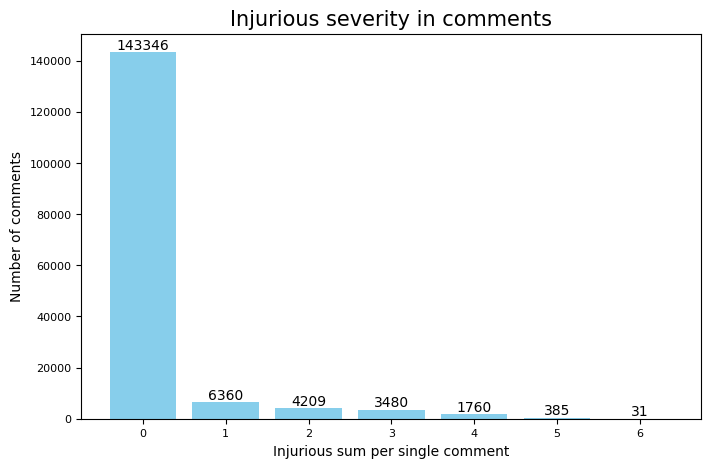

In [9]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

pl.plot_bar(col_names, comments_per_injurious, title='Injurious severity in comments', \
         xlabel='Injurious sum per single comment', ylabel='Number of comments', color='skyblue', \
            xticks_settings={'fontsize':8}, yticks_settings={'fontsize':8})

In [10]:
injurious = df.drop(columns=['sum_injurious'])
non_injurious = pd.Series(data=comments_per_injurious[0], index=["none"])
injurious_type_sum = pd.concat([injurious.sum(axis=0), non_injurious]).sort_values(ascending=False)
injurious_type_sum

none             143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64

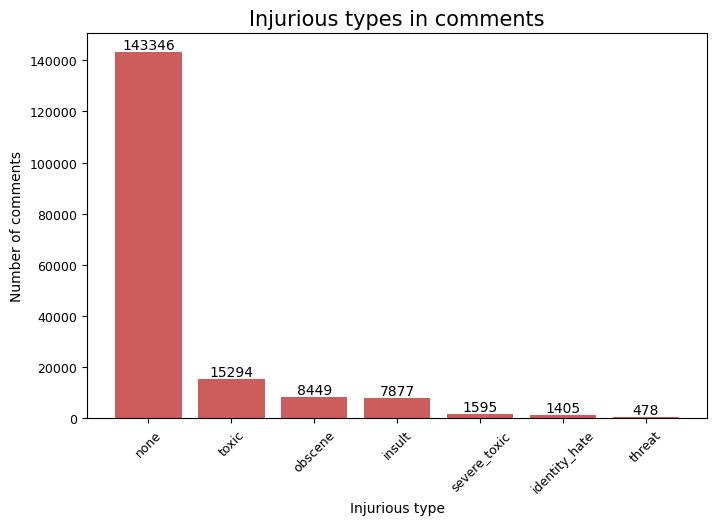

In [11]:
pl.plot_bar(injurious_type_sum.index, injurious_type_sum, title='Injurious types in comments', \
         xlabel='Injurious type', ylabel='Number of comments', color='indianred', \
            xticks_settings={'rotation':45, 'fontsize':9}, yticks_settings={'fontsize':9})

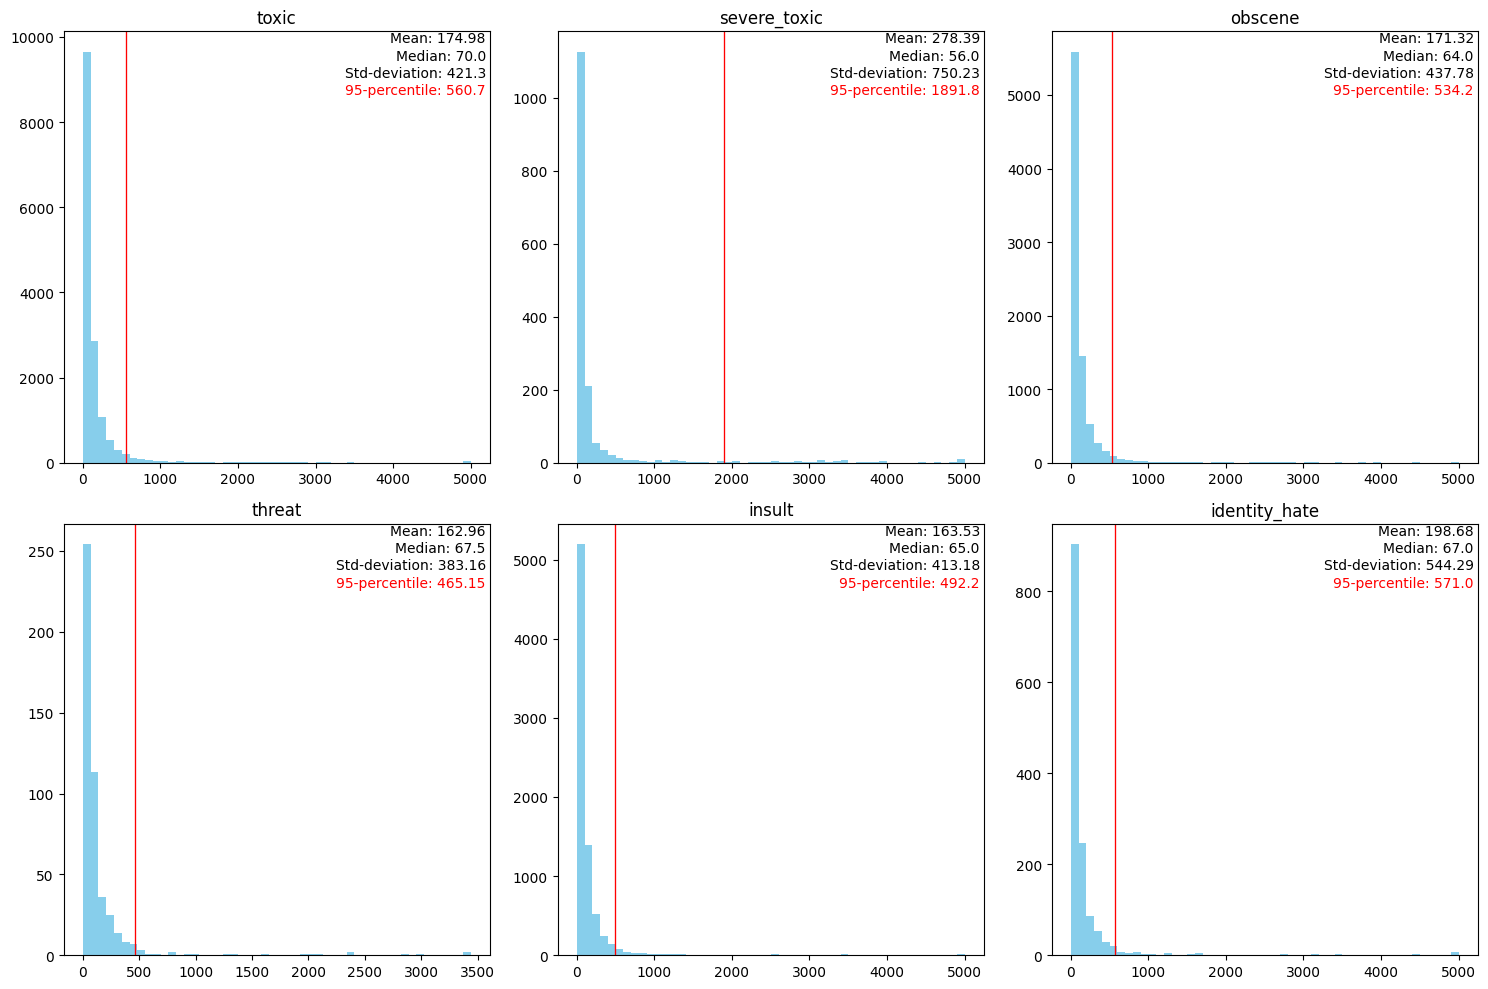

In [12]:
pl.plot_stats(dataframe=df, categories=injurious.columns, data=preprocessed_text)

In [13]:
injurious[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [14]:
def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val


In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.3)


X_train[0:3]
y_train[0:3]

['writing biographies want create biography please first read blp follow guidance put front name way removed per guidelines read see wikipedia article wizard advises bit editing first',
 'asking already initiated another sock puppet investigation please wait verdict way proves hound orchestrated total attack wiki personality purpose eliminating wiki opinion latest dispute article albania alexikoua remove sourced consensual material cia world fact book official housing census united nations confirm already proven rows meat alexikoua addition noticed unethical act user alexikoua forward admin opinion comment removed talk page demonstrated purpose changing artificially established consensus denied alexikoua know yet wiki definition sure get trying say days block verdict account',
 'checked pome indeed right legend fate amrod telufinwë one burned ships amras pityafinwë ambarussa survived presumably still died third kinslaying follow pome strictly curufin fëanor fourth son caranthir fifth']

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [17]:
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1000)

X_train.shape
y_train.shape

Words number: OrderedDict([('writing', 933), ('biographies', 331), ('want', 4648), ('create', 1096), ('biography', 296), ('please', 11964), ('first', 4370), ('read', 3263), ('blp', 282), ('follow', 639), ('guidance', 86), ('put', 2474), ('front', 283), ('name', 4426), ('way', 4442), ('removed', 2632), ('per', 977), ('guidelines', 1313), ('see', 8559), ('wikipedia', 17657), ('article', 22694), ('wizard', 139), ('advises', 9), ('bit', 1316), ('editing', 3873), ('asking', 486), ('already', 2164), ('initiated', 47), ('another', 2622), ('sock', 477), ('puppet', 169), ('investigation', 180), ('wait', 455), ('verdict', 29), ('proves', 131), ('hound', 17), ('orchestrated', 4), ('total', 380), ('attack', 1172), ('wiki', 2035), ('personality', 96), ('purpose', 425), ('eliminating', 22), ('opinion', 1557), ('latest', 232), ('dispute', 747), ('albania', 68), ('alexikoua', 15), ('remove', 2137), ('sourced', 590), ('consensual', 10), ('material', 1416), ('cia', 85), ('world', 1948), ('fact', 3051), 

(63828, 1250)

(63828, 6)

In [18]:
def build_model(name, model, models_dir, optmizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
  fit = False
  if name in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {name}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
      model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
      fit = True
    else:
      model = load_model(models_dir+'/'+name)
  else:
    model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
    fit = True
  return model, fit

In [19]:
def convert_probability_to_value(arr:np.array, threshold=.5):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = 1 if arr[i][j] > threshold else 0
    return arr

In [20]:
early_stopping = EarlyStopping()
batch_log = md.BatchLogger()

In [ ]:
clear_session()

lstm_model_history="base_LSTM.plk"
lstm_model_name = "LSTM_model.keras"
fit = False

lstm_model = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_model, fit = build_model(
   lstm_model_name,
   lstm_model,
   models_dir,
   optmizer='adam',
   loss='binary_crossentropy',
   metrics=['accuracy']
)

lstm_model.summary()

In [ ]:
if fit:
    lstm_history = lstm_model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    pickle.dump(lstm_history, open(storage_folder+"/"+lstm_model_history, 'wb'))
    if COLAB:
        lstm_model.save("./models/"+lstm_model_name)
    else:
        lstm_model.save("../models/"+lstm_model_name)
else:
      lstm_history = pickle.load(open(storage_folder+"/"+lstm_model_history, 'rb'))


In [ ]:
lstm_history.history

In [ ]:
y_pred = convert_probability_to_value(lstm_model.predict(X_test))


In [ ]:
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)

In [ ]:
val_loss_per_epoch = lstm_history.history['val_loss']
val_accuracy_per_epoch = lstm_history.history['val_accuracy']

type(val_loss_per_epoch)
len(val_loss_per_epoch)
len(batch_log.batch_loss)
stretch_loss = []
stretch_accuracy = []

for i in range(len(val_loss_per_epoch)):
    stretch_loss += [val_loss_per_epoch[i]]*int(len(batch_log.batch_loss) / len(val_loss_per_epoch))
    stretch_accuracy += [val_accuracy_per_epoch[i]]*int(len(batch_log.batch_accuracy) / len(val_accuracy_per_epoch))

stretch_loss = np.array(stretch_loss)
stretch_accuracy = np.array(stretch_accuracy)
stretch_loss.shape
stretch_accuracy.shape

In [ ]:
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

## Weighted loss function

In [ ]:
w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

In [ ]:
clear_session()

lstm_weight_hist="LSTM_with_weights.plk"
lstm_weight_name = "LSTM_with_weights.keras"
fit = False

lstm_weight = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_weight, fit = build_model(
   lstm_weight_name,
   lstm_weight,
   models_dir,
   optmizer='adam',
   loss=md.weighted_binary_crossentropy(w0, w1),
   metrics=['f1-score']
)

lstm_weight.summary()

In [ ]:
if fit:
    lstm_weight_history = lstm_weight.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    pickle.dump(lstm_weight_history, open(storage_folder+"/"+lstm_weight_hist, 'wb'))
    pickle.dump(batch_log, open(storage_folder+"/lstm_batch_log.plk", 'wb'))
    if COLAB:
        lstm_weight.save("./models/"+lstm_weight_name)
    else:
        lstm_weight.save("../models/"+lstm_weight_name)
else:
    lstm_history = pickle.load(open(storage_folder+"/"+lstm_weight_hist, 'rb'))
    batch_log = pickle.load(open(storage_folder+"/lstm_batch_log.plk", 'rb'))




In [ ]:
y_pred = convert_probability_to_value(lstm_weight.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)


## RNN with GRU layer

In [ ]:
clear_session()
rnn_gru_model_keras = "rnn_gru_model.keras"
rnn_gru_model_history = "history_rnn_gru.plk"

fit = False

if rnn_gru_model_keras in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {rnn_gru_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        rnn_gru_model = md.GRU_RNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
        rnn_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1-score'])
        fit = True
    else:
        rnn_gru_model = load_model("../models/"+rnn_gru_model_keras)

else:
    rnn_gru_model = md.GRU_RNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
    rnn_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    fit = True

rnn_gru_model.summary()


In [ ]:
if fit:
    history_rnn_gru = rnn_gru_model.fit(X_train, y_train,
                        epochs=5, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    pickle.dump(history_rnn_gru, open(storage_folder+"/"+"history_rnn_gru.plk", 'wb'))
    rnn_gru_model.save(models_dir+"/rnn_gru_model.keras")


else:
    history_rnn_gru = pickle.load(open(storage_folder+"/"+rnn_gru_model_history, 'rb'))

history_rnn_gru.history

In [ ]:
y_pred_rnn_gru = convert_probability_to_value(rnn_gru_model.predict(X_test))

In [ ]:
pl.print_confusion_matrix(y_test, y_pred_rnn_gru, injurious.columns)

## Model with LSTM and Convolutional layer

In [ ]:

cnn_model_keras = "cnn_model.keras"
cnn_model_history = "history_cnn.plk"

if cnn_model_keras in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {cnn_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    else:
        cnn_model = load_model("../models/"+cnn_model_keras)
else:
    cnn_model = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

cnn_model.summary()


In [ ]:
if answer.lower() == 'y' or answer == 'yes':
    history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    pickle.dump(history_cnn, open(storage_folder+"/"+cnn_model_history, 'wb'))
    cnn_model.save(models_dir+'/'+cnn_model_keras)   
else:
    history_cnn = pickle.load(open(storage_folder+"/"+cnn_model_history, 'rb'))

In [ ]:
y_pred_cnn = convert_probability_to_value(cnn_model.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred_cnn, injurious.columns)

In [ ]:
y_train.T[5]
range(len(y_train[0]))

In [ ]:
clear_session()
cnn_model_with_w = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
cnn_model_with_w.compile(optimizer='adam', loss=md.weighted_binary_crossentropy(w0, w1), metrics=['f1-score'])
history_cnn_with_w = cnn_model_with_w.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

In [ ]:
y_pred_cnn_with_w = convert_probability_to_value(cnn_model_with_w.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred_cnn_with_w, injurious.columns)


## ANOTHER MODEL

In [21]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.3)


def balance_training_set(X_train, y_train, random_over_sampling=0.5, random_under_sampling=0.5):
    indexes = [[],[],[],[],[],[],[]]
    for i in range(len(y_train)):
        indexes[np.cumsum(y_train[i])[-1]].append(i)
    
    print([sublist[0] for sublist in indexes])
    lenghts = [len(sublist) for sublist in indexes]
    id_class_with_max = lenghts.index(max(lenghts))

    if random_over_sampling > 0:
        for i in range(len(indexes)):
            if i != id_class_with_max:
                list_of_idx_to_add = np.random.choice(indexes[i], int(random_over_sampling*len(indexes[i])), replace=True)
                X_train = np.concatenate((X_train, [X_train[j] for j in list_of_idx_to_add]), axis=0)
                y_train = np.concatenate((y_train, [y_train[j] for j in list_of_idx_to_add]), axis=0)
    
    if random_under_sampling > 0:
        list_of_idx_to_remove = np.random.choice(indexes[id_class_with_max], int(random_under_sampling*len(indexes[id_class_with_max])), replace=False)
        X_train = np.delete(X_train, list_of_idx_to_remove, axis=0)
        y_train = np.delete(y_train, list_of_idx_to_remove, axis=0)

    return X_train, y_train

X_train, y_train = balance_training_set(X_train, y_train, random_over_sampling=0.75)
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1000)

X_train.shape, y_train.shape



[0, 20, 4, 19, 9, 514, 96]
Words number: OrderedDict([('writing', 529), ('biographies', 171), ('want', 2927), ('create', 581), ('biography', 151), ('please', 6629), ('first', 2390), ('read', 1892), ('blp', 147), ('follow', 354), ('guidance', 43), ('put', 1453), ('front', 186), ('name', 2395), ('way', 2583), ('removed', 1418), ('per', 499), ('guidelines', 693), ('see', 4669), ('wikipedia', 10154), ('article', 12071), ('wizard', 63), ('advises', 4), ('bit', 721), ('editing', 2207), ('hmm', 57), ('appears', 472), ('somebody', 232), ('changed', 586), ('one', 6634), ('templates', 223), ('make', 3035), ('orientation', 23), ('different', 1023), ('vandalism', 1796), ('much', 2134), ('changing', 278), ('back', 1943), ('dont', 759), ('like', 7733), ('sure', 1459), ('gay', 868), ('december', 212), ('utc', 1641), ('stylistic', 6), ('consistency', 61), ('whatever', 537), ('prompted', 12), ('reversion', 54), ('entire', 453), ('edit', 3886), ('note', 1380), ('talk', 7594), ('page', 10172), ('internal

((40044, 1243), (40044, 6))

In [24]:
clear_session()

w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

cnn_model_2_keras = "cnn_model_2.keras"
cnn_model_2_history = "history_cnn_2.plk"


if cnn_model_2_keras in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {cnn_model_2_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model_2 = md.CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
        cnn_model_2.compile(optimizer='adam', loss=md.weighted_binary_crossentropy(w0, w1), metrics=[md.F1Score(), 'accuracy'])

    else:
        custom_objects = {'loss': md.weighted_binary_crossentropy(w0, w1)}
        cnn_model_2 = load_model("../models/"+cnn_model_2_keras, custom_objects=custom_objects)
else:
    clear_session()
    cnn_model_2 = md.CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
    cnn_model_2.compile(optimizer='adam', loss=md.weighted_binary_crossentropy(w0, w1), metrics=[md.F1Score(), 'accuracy'])

cnn_model_2.summary()

([0.6835780129737111,
  0.5146514497223935,
  0.5862442537990806,
  0.5039136234364382,
  0.5793905720982724,
  0.5126091297780281],
 [1.861818858099312,
  17.563157894736843,
  3.3987438465455777,
  64.37942122186494,
  3.64898851831602,
  20.326903553299495])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1243, 256)         16499712  
                                                                 
 dropout (Dropout)           (None, 1243, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, 1243, 128)         98432     
                                                                 
 max_pooling1d (MaxPooling1  (None, 621, 128)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [25]:
answer = "y"
if answer.lower() == 'y' or answer == 'yes':
    history_cnn_2 = cnn_model_2.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])

    pickle.dump(history_cnn_2, open(storage_folder+"/"+cnn_model_2_history, 'wb'))
    cnn_model_2.save(models_dir+'/'+cnn_model_2_keras)   
else:
    history_cnn_2 = pickle.load(open(storage_folder+"/"+cnn_model_2_history, 'rb'))

Epoch 1/10
626/626 [==============================] - 803s 1s/step - loss: 0.4112 - f1_score: 0.0416 - accuracy: 0.9117 - val_loss: 0.0910 - val_f1_score: 0.3225 - val_accuracy: 0.9938
Epoch 2/10
626/626 [==============================] - 867s 1s/step - loss: 0.1703 - f1_score: 0.4619 - accuracy: 0.9835 - val_loss: 0.0709 - val_f1_score: 0.5732 - val_accuracy: 0.9938
Epoch 3/10
626/626 [==============================] - 730s 1s/step - loss: 0.1582 - f1_score: 0.5331 - accuracy: 0.9841 - val_loss: 0.0722 - val_f1_score: 0.5373 - val_accuracy: 0.9938
Epoch 4/10
626/626 [==============================] - 734s 1s/step - loss: 0.1542 - f1_score: 0.5543 - accuracy: 0.9842 - val_loss: 0.0653 - val_f1_score: 0.5452 - val_accuracy: 0.9938
Epoch 5/10
626/626 [==============================] - ETA: 0s - loss: 0.1502 - f1_score: 0.5651 - accuracy: 0.9842
Stop training at epoch: 5
626/626 [==============================] - 748s 1s/step - loss: 0.1502 - f1_score: 0.5651 - accuracy: 0.9842 - val_loss

1496/1496 [==============================] - 219s 146ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


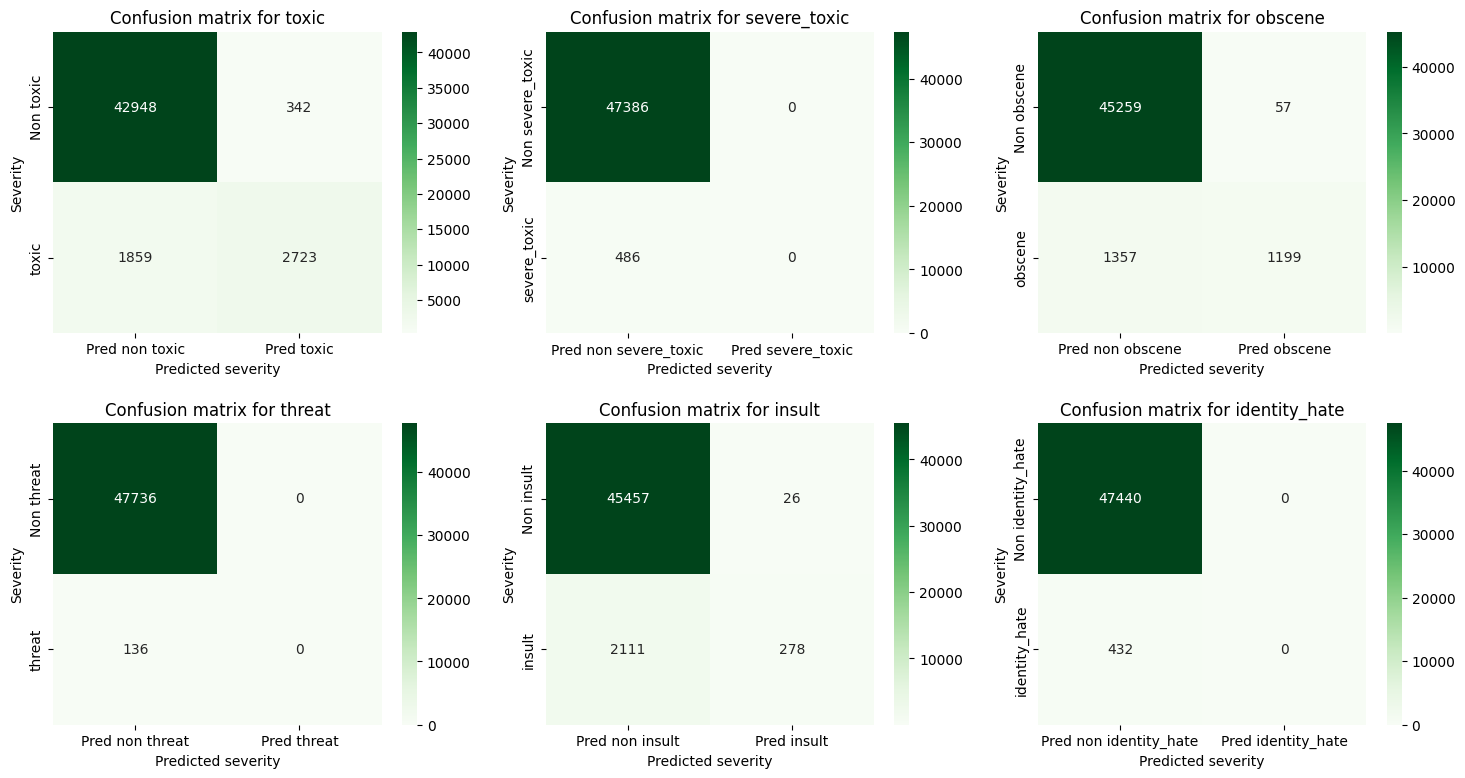

In [26]:
y_pred_cnn_2 = convert_probability_to_value(cnn_model_2.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred_cnn_2, injurious.columns)